finetuning the 'aquib1011/maize-leaf-disease-convnext' from huggingfaces


In [ ]:
!pip3 install transformers datasets
#uncomment the following line if you are running your own jupyter notebook in a fresh enviroment
!pip3 install -q numpy tqdm torch torchvision torchaudio
!pip3 install -q numpy tqdm torch torchvision torchaudio matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 13.1 MB/s eta 0:00:00


For reproducibility, we fix our seed to a value.

In [ ]:
seed = 2024

Now let's load our dataset. We uploaded the dataset on hugging face.

After downloading the dataset, we inspect it using a simple print call. This dataset has 727 images in the train set and 556 on the test set, and the dataset comes with a validation set of 336 images.

In [ ]:
from datasets import load_dataset, concatenate_datasets
dataset = load_dataset("muAtarist/maize_diseases_dataset",name="default")
dataset


Resolving data files:   0%|          | 0/727 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/336 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/556 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/727 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/336 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/556 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 727
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 336
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 556
    })
})

To convert between the class ids and the label name, we need to generate a mapping for id2label and label2id. These maps will also be used for loading the pre-trained model.

In [ ]:
labels = dataset["train"].features["label"].names
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}

Now that we have our mapping, we should investigate the dataset a bit more before starting to process the dataset. Let's look into the distribution of the classes in the train set.

First, we write a function that counts every occurrence of each label in the train and test dataset, then we normalize the result and plot the difference between them.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def normalize(d, target=1.0):
   raw = sum(d.values())
   factor = target/raw
   return {key:value*factor for key,value in d.items()}

def getLabelDistribution(dataset, split):
  labels = dataset[split].features["label"].names
  dist = {k:0 for k in labels}

  for row in dataset[split]:
    dist[id2label[row['label']]] +=1

  return normalize(dist)

def get_diff(train_dist, test_dist):
  labels = list()
  diffs = list()
  for (k,v_train), (_ ,v_test) in zip(train_dist.items(), test_dist.items()):
    diff = abs(v_train - v_test) * 100
    labels.append(k)
    diffs.append(diff)

  y_pos = np.arange(len(labels))
  plt.bar(y_pos, diffs)
  plt.show()

The plot looks like the classes are unevenly distributed. So we merge all three datasets into one and create our own test/train splits.

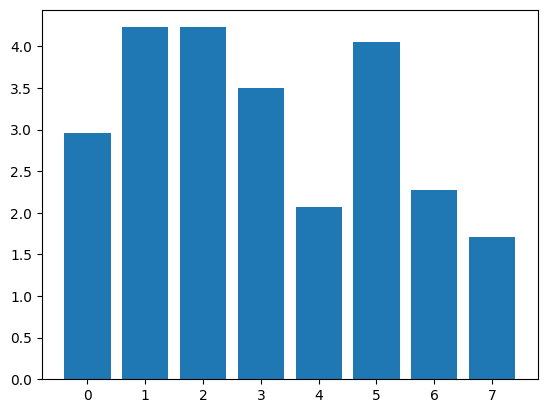

In [ ]:
train_dist = getLabelDistribution(dataset, "train")
test_dist = getLabelDistribution(dataset, "test")
get_diff(train_dist, test_dist)

First, we merge all the datasets into one Dataset object, and then we create a new DatasetDict object with the train_test_split function. It is only essential to set stratify_by_column to labels to distribute the labels evenly.  

In [ ]:
dataset = concatenate_datasets([dataset["train"], dataset["validation"], dataset["test"]])
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label")

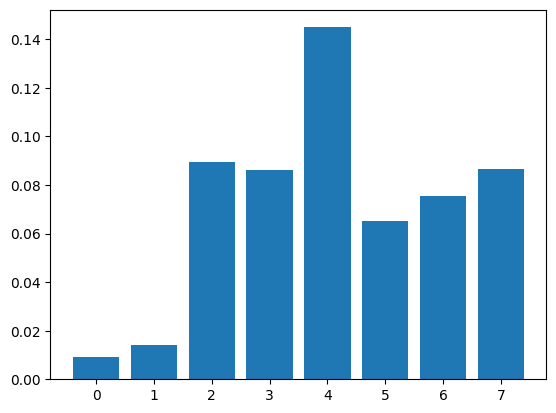

In [ ]:
train_dist = getLabelDistribution(dataset, "train")
test_dist = getLabelDistribution(dataset, "test")
get_diff(train_dist, test_dist)

Now we import and use the ConvNextFeatureExtractor from the transformers library of the hugging face API and load the model config from the pre-trained model.

In [ ]:
from transformers import ConvNextFeatureExtractor

feature_extractor = ConvNextFeatureExtractor.from_pretrained("aquib1011/maize-leaf-disease-convnext")

preprocessor_config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


Now we build two transform pipelines, one for the train data and one for the test data. The main difference between both pipelines is that the train pipeline has image augmentations to prevent overfitting during training. The test pipeline has only the necessary steps to prepare the data for the model. Then we convert the image to rgb values and apply the transformation.

In [ ]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
size = feature_extractor.size["shortest_edge"]

transform_train = Compose(
    [
     RandomResizedCrop(size),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)
transform_test = Compose(
    [
      Resize(size),
      ToTensor(),
      normalize
    ]
)

def train_transforms(examples):
  examples["pixel_values"] = [transform_train(image.convert("RGB")) for image in examples["image"]]
  return examples

def test_transforms(examples):
  examples["pixel_values"] = [transform_test(image.convert("RGB")) for image in examples["image"]]
  return examples

train_dataset = dataset["train"].with_transform(train_transforms)
test_dataset = dataset["test"].with_transform(test_transforms)


Using the AutoModelForImageClassification Class, we download the pre-trained model and change the size of the output layer to the number of our labels in the dataset. We also provide it with our id2label and label2id maps and set the parameter ignore_mismatched_sizes to True, so we can change the last layer without throwing an error.

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("aquib1011/maize-leaf-disease-convnext",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/111M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at aquib1011/maize-leaf-disease-convnext and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


To use the GPU for training and testing, we push the model to the GPU if one is available.

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

We define a custom collate_fn function. This function is applied to the batch of samples before they are passed to the model for training or evaluation. We use collate_fn to define how to preprocess the input data to obtain equally sized tensors.

We enable shuffling for the train_dataloader and set our previously defined seed for the random function.

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "label": labels}

batch_size = 2
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(seed))
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size)

To train and test our model, we need to write the test and train function. The test function starts with setting the model in the evaluation mode. In this mode the model doesn't update the its parameters.

We iterate over all batches, pushing them to the GPU if one is available,  passing them through the model, and calculating their loss value.

In [ ]:
from tqdm.notebook import tqdm
def test(model, dataloader):
  print("Starting testing")
  results = list()
  model.eval()

  correct = 0
  total = 0
  t_loss = 0.

  with tqdm(dataloader, unit=" it") as tepoch:
    for idx, batch in enumerate(tepoch):
      tepoch.set_description(f"Testing model")
      # move batch to GPU
      batch = {k:v.to(device) for k,v in batch.items()}
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"],
                          labels=batch["label"])

      loss, logits = outputs.loss, outputs.logits

      # metrics
      total += batch["label"].shape[0]
      predicted = logits.argmax(-1)
      correct += (predicted == batch["label"]).sum().item()
      t_loss += loss.item()
      tepoch.set_postfix(loss=t_loss/total, accuracy=100. * correct/total)
  acc = 100. * correct/total
  print(f"Test completed!\nAverage accuracy: {acc:.3f}%")

We do almost the same for the train function, but instead of model.eval(), we set the model to model.train(). We also define an optimizer to reduce the loss while training.

In [ ]:
def train(model, dataloader, epochs):
  print("Starting Training:")
  optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

  model.train()
  for epoch in range(epochs):
    correct = 0
    total = 0
    t_loss = 0.

    with tqdm(dataloader) as tepoch:
      for idx, batch in enumerate(tepoch):
        # move batch to GPU
        tepoch.set_description(f"Epoch {epoch}/{epochs-1}")
        batch = {k:v.to(device) for k,v in batch.items()}

        #reset the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"],
                        labels=batch["label"])

        loss, logits = outputs.loss, outputs.logits
        # back propagate
        loss.backward()
        optimizer.step()

        # metrics
        total += batch["label"].shape[0]
        predicted = logits.argmax(-1)
        correct += (predicted == batch["label"]).sum().item()
        t_loss += loss.item()

        tepoch.set_postfix(loss=t_loss/total, accuracy=100. * correct/total)

Now we test our test set on the pre-trained model to see how it performs without training.

In [ ]:
test(model, test_dataloader)

Starting testing


  0%|          | 0/162 [00:00<?, ? it/s]

Test completed!
Average accuracy: 9.568%


We train our model with our data

In [ ]:
train(model, train_dataloader, 20)

Starting Training:


  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/648 [00:00<?, ?it/s]

We can test our model again!

In [ ]:
test(model, test_dataloader)

NameError: name 'test' is not defined

Saving the model and feature extractor

In [ ]:
# Save the model and feature extractor
model.save_pretrained("maize_disease_model")
feature_extractor.save_pretrained("maize_disease_model")

Importing and logging into huggingfaces

In [ ]:
from secret import token
# Login to Hugging Face
from huggingface_hub import login, HfApi
login(token=token)
api = HfApi()

Saving model and feature_extractor to hugging faces

In [ ]:

api.create_repo(repo_id="muAtarist/maize_disease_model", exist_ok=True)
model.push_to_hub("muAtarist/maize_disease_model")
feature_extractor.push_to_hub("muAtarist/maize_disease_model")

Loading saved model for testing

In [ ]:
# Load the model from Hugging Face
from transformers import AutoModelForImageClassification
model = AutoModelForImageClassification.from_pretrained("muAtarist/maize_disease_model")